In [1160]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import math
import random


In [1161]:


def gen_momentum_vectors(N):
    #generate random 2d, unit vectors ---> (x, z)
    x_vals = np.random.uniform(-1, 1, size = N)
    z_vals = np.random.uniform(-1, 1, size = N)
    
    J_plus = np.asarray([np.asarray([x, z]).reshape(2,1) for x, z in zip(x_vals, z_vals)])
    J_minus = np.asarray([-1*Jp for Jp in J_plus])
    
    return [J_plus, J_minus]


vecs = gen_momentum_vectors(10)


vecs[1]    


array([[[ 0.95163306],
        [-0.8734277 ]],

       [[ 0.29855543],
        [-0.70492175]],

       [[-0.24631742],
        [ 0.21457195]],

       [[ 0.18398433],
        [ 0.65304248]],

       [[-0.43894202],
        [-0.89049144]],

       [[-0.55730002],
        [-0.14506548]],

       [[-0.11697175],
        [ 0.76589143]],

       [[ 0.13295259],
        [-0.37976212]],

       [[-0.3699462 ],
        [-0.82606696]],

       [[ 0.0407345 ],
        [-0.79733074]]])

In [1162]:
vecs[0]

array([[[-0.95163306],
        [ 0.8734277 ]],

       [[-0.29855543],
        [ 0.70492175]],

       [[ 0.24631742],
        [-0.21457195]],

       [[-0.18398433],
        [-0.65304248]],

       [[ 0.43894202],
        [ 0.89049144]],

       [[ 0.55730002],
        [ 0.14506548]],

       [[ 0.11697175],
        [-0.76589143]],

       [[-0.13295259],
        [ 0.37976212]],

       [[ 0.3699462 ],
        [ 0.82606696]],

       [[-0.0407345 ],
        [ 0.79733074]]])

In [1163]:
def gen_measurement_vector(theta):
    #generate a measurement vector --> (x,z)
    #functions assume radians
    components = np.array(([np.sin(theta),np.cos(theta)]))
    magnitude = math.sqrt(sum(pow(element, 2) for element in components))
    unit_vector = components/magnitude
    return unit_vector



gen_measurement_vector(np.pi/4)

array([0.70710678, 0.70710678])

In [1164]:





def experiment(theta, number_of_momentum_vectors):
    theta_11 = 0*theta
    theta_12 = 2*theta
    theta_21 = theta
    theta_22 = 3*theta
    #creates 4 experiement vectors from input theta
    alpha_1 = gen_measurement_vector(theta_11)
    alpha_2 = gen_measurement_vector(theta_12)
    beta_1 = gen_measurement_vector(theta_21)
    beta_2 = gen_measurement_vector(theta_22)
    
    #used to calcuate correlators 
    alpha_1_beta_1 = [] 
    alpha_2_beta_1 = [] 
    alpha_1_beta_2 = [] 
    alpha_2_beta_2 = []
    
    #creates N momentum vectors
    momentum_vectors = gen_momentum_vectors(number_of_momentum_vectors)
   
    #does experiment
    for up_momentum_vectors in momentum_vectors[0]:
        #randomly chooses an alpha and a beta
        #print(np.random.uniform(0, 1, size = 1)[0])
        counter_alpha = 0 
        counter_beta = 0
        if random.randint(1, 2)  == 1:
            measurement_1 = alpha_1
            counter_alpha += 1
        else: 
            measurement_1 = alpha_2
            counter_alpha += 2
            
        if random.randint(1, 2) == 1:
            measurement_2 = beta_1
            counter_beta += 1
        else: 
            measurement_2 = beta_2
            counter_beta += 2
        #normalize momentum vectors
        components = np.array(up_momentum_vectors)
        magnitude = math.sqrt(sum(pow(element, 2) for element in components))
        unit_vector = components/magnitude
        
       
        
        #measurements
        a_alpha_i = np.sign(np.dot(measurement_1,unit_vector))
        b_beta_i = -np.sign(np.dot(measurement_2,unit_vector))
        measurement = a_alpha_i[0]*b_beta_i[0]
        
        
        #sorts measruements into 4 correlators to later calculate CHSH correlator
        
        #problem here alpha_2_beta_1 array not populating
        if counter_alpha == 1 and counter_beta == 1:
            alpha_1_beta_1.append(measurement)
        elif counter_alpha == 1 and counter_beta == 2: 
            alpha_1_beta_2.append(measurement)
        elif counter_alpha == 2 and counter_beta == 1:
            alpha_2_beta_1.append(measurement)
        elif counter_alpha == 2 and counter_beta == 2:
            alpha_2_beta_2.append(measurement)
        
    #print(alpha_1_beta_1,alpha_1_beta_2,alpha_2_beta_1,alpha_2_beta_2)
        
    
    correlator_11 = np.sum(alpha_1_beta_1)/len(alpha_1_beta_1)
    correlator_12 = np.sum(alpha_1_beta_2)/len(alpha_1_beta_2)
    correlator_21 = np.sum(alpha_2_beta_1)/len(alpha_2_beta_1) 
    correlator_22 = np.sum(alpha_2_beta_2)/len(alpha_2_beta_2)
    
    S_classic = correlator_11 + correlator_12 + correlator_21 - correlator_22    
    
    S_quantum = -np.cos(theta_11-theta_21)+np.cos(theta_11-theta_22)-np.cos(theta_12-theta_21)-np.cos(theta_12-theta_22)
        
    
    return S_classic, S_quantum

y_axis_classical = []
y_axis_quantum = []
x_axis = []
number_of_experiments = 2000
angle_divisions = 100
for angle in np.linspace(0,2*np.pi,angle_divisions):
    classic, quantum= experiment(angle,number_of_experiments)
    print(classic,quantum)
    #print("Correlator: ", experiment(angle,2000), "Angle(in radians): ", angle)
    x_axis.append(angle)
    y_axis_classical.append(classic)
    y_axis_quantum.append(quantum)
    #print(experiment(angle,number_of_experiments), angle)
        


-2.0 -2.0
-1.6323348290424127 -2.117826382550207
-1.0592323644813346 -2.409568182015872
-0.2534663902830986 -2.7129428558805495
0.07152480947205564 -2.8256588799198505
0.5643350973530927 -2.5817613543727824
0.6207224641849516 -1.9162623746790426
0.09747437277186677 -0.894677484071364
0.11015856120123578 0.3033752840207148
-0.35347578186851003 1.4409245158518482
-0.5625780518700719 2.300712395925398
-0.18723229248418466 2.755275759263219
0.11441852117825424 2.805238378405335
0.5570630092498439 2.572390679595034
1.2532761187297004 2.2503117866524835
1.8033399175695184 2.0304687137756368
1.7653414503730653 2.0304687137756368
1.344467297055902 2.2503117866524835
0.6618907940277945 2.5723906795950335
0.08857743939610108 2.8052383784053347
-0.36535128277974876 2.755275759263218
-0.6597998939058114 2.3007123959253972
-0.5855372821160689 1.4409245158518496
-0.08861296285042336 0.30337528402071456
0.16900522342215252 -0.894677484071366
0.4681248551625413 -1.9162623746790426
0.440184184345675 -2

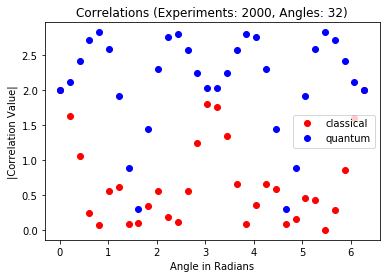

In [1165]:
plt.xlabel('Angle in Radians')
plt.ylabel('|Correlation Value|')
plt.title(f'Correlations (Experiments: {number_of_experiments}, Angles: {angle_divisions})')
plt.plot(x_axis,np.abs(y_axis_classical),'ro')
plt.plot(x_axis,np.abs(y_axis_quantum),'bo')
plt.legend(["classical", "quantum"])